In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("input/Climate.csv")
data['date'] = pd.to_datetime(data['date'],format="%Y-%m")
data = data.set_index('date')
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


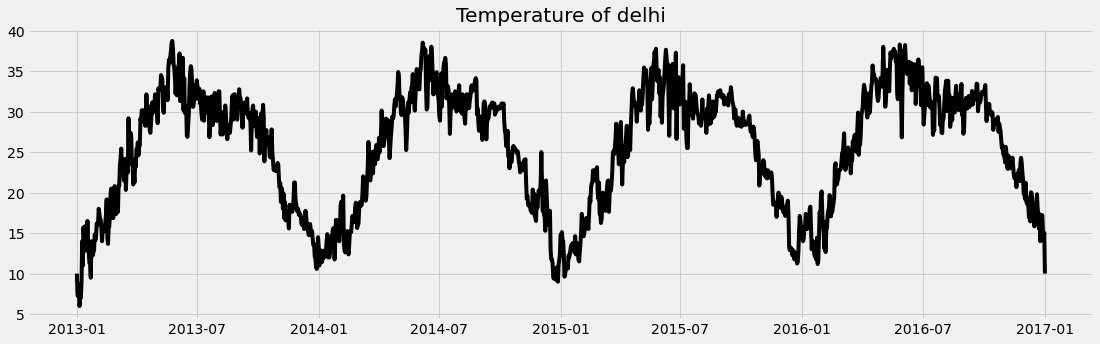

In [3]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data['meantemp'],color='black')
plt.title("Temperature of delhi")
plt.show()

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time.

For KPSS test,

The Null Hypothesis : The series is stationary when p-value >0.05 Alternate Hypothesis: The series is not stationary when p-value <= 0.5

In [4]:
#loading kpss from statsmodel
from statsmodels.tsa.stattools import kpss

result = kpss(data['meantemp'])
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

KPSS Statistic: 0.1948270141059301
p-value: 0.1
num lags: 24
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## AutoCorrelation function 自我相關 (序列相關)

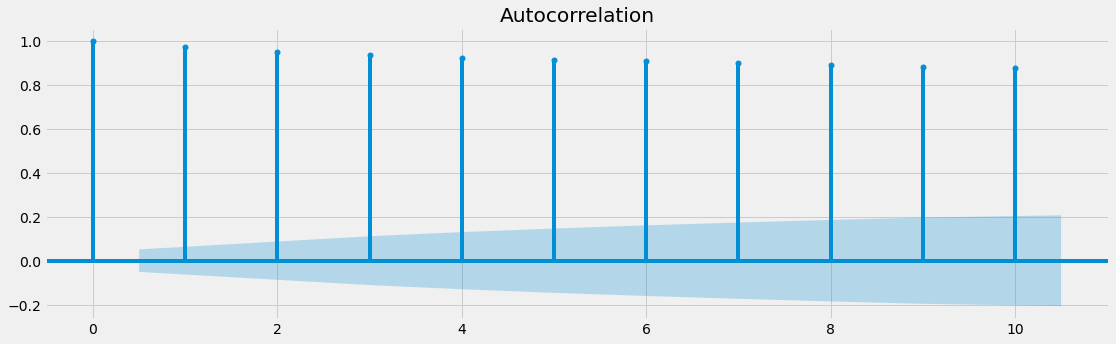

In [5]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['meantemp'], ax=plt.gca(), lags=10)
plt.show()

## Partial Auto Correleation Function 偏自相關函數 (PACF)
偏自相關函數 (PACF) 給出了平穩時間序列與其自身滯後值的偏相關，在所有較短的滯後處對時間序列的值進行回歸。它與不控制其他滯後的自相關函數形成對比。

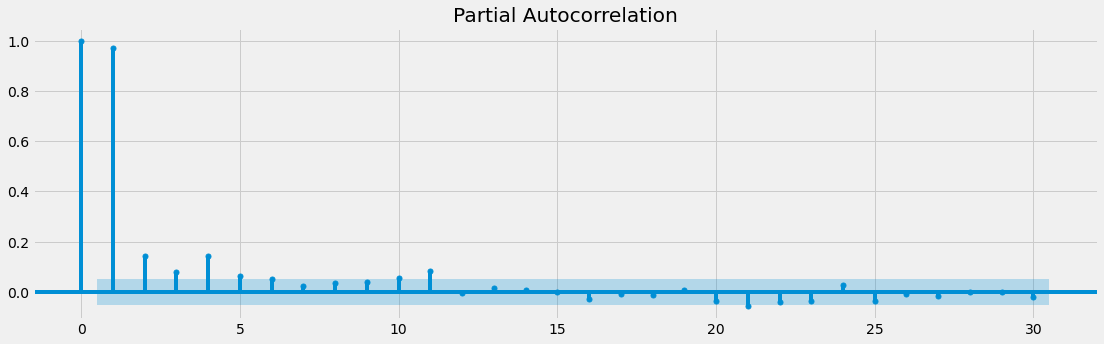

In [6]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['meantemp'], ax=plt.gca(), lags=30)
plt.show()

In [7]:
# Splitting Dataset
length_train = 1046
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## ARIMAX model

In [8]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train['meantemp'], order=(1,0,3), exog= train['humidity'])
model_fit = model.fit()
print(model_fit.params)

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63773D+00    |proj g|=  4.13895D-02

At iterate    5    f=  1.63722D+00    |proj g|=  2.78384D-03

At iterate   10    f=  1.63695D+00    |proj g|=  2.07057D-04

At iterate   15    f=  1.63686D+00    |proj g|=  6.86604D-03

At iterate   20    f=  1.63657D+00    |proj g|=  1.07258D-02

At iterate   25    f=  1.63656D+00    |proj g|=  1.92621D-03

At iterate   30    f=  1.63656D+00    |proj g|=  8.08464D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


In [9]:
y_arimax = data.copy()
y_arimax['arimax_forecast'] = model_fit.predict(test['meantemp'].index.min(),
                                                test['meantemp'].index.max(),
                                                exog= test['humidity'])

### Plot train, test and forecast

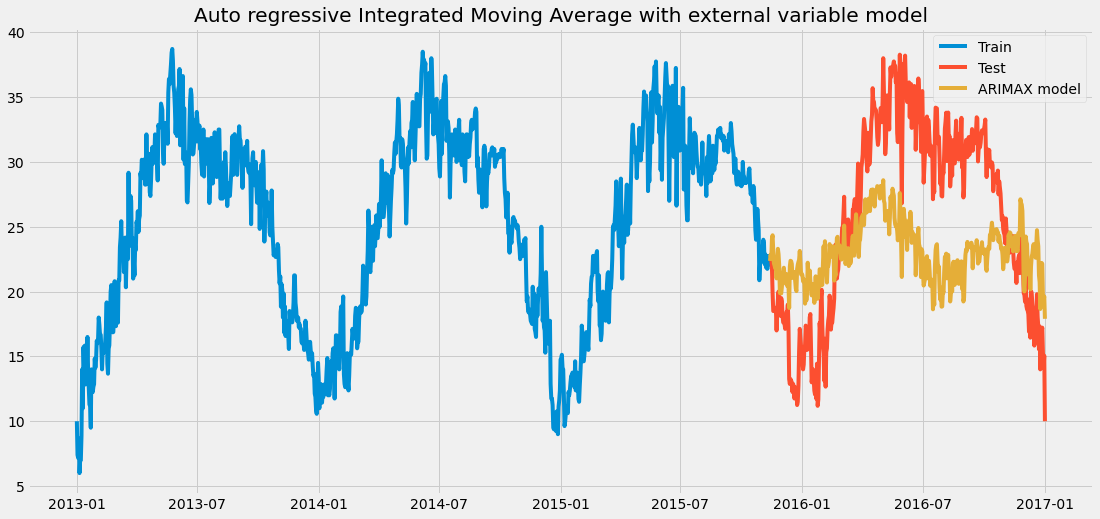

In [10]:
plt.figure(figsize=(17,8))

plt.plot(train['meantemp'], label = 'Train')
plt.plot(test['meantemp'], label = 'Test')
plt.plot(y_arimax['arimax_forecast'][test['meantemp'].index.min():], 
         label = 'ARIMAX model')

plt.legend()
plt.title('Auto regressive Integrated Moving Average with external variable model')
plt.show()

# Splitting Train and Test data

In [11]:
length_train = 1046
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

## SARIMAX Model

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['meantemp'], order=(7,0,3), seasonal_order=(2,1,1,12), exog =train['humidity'])
model_fit = model.fit()
print(model_fit.params)

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78034D+00    |proj g|=  2.28086D+00


 This problem is unconstrained.



At iterate    5    f=  1.77936D+00    |proj g|=  3.81019D-01

At iterate   10    f=  1.70321D+00    |proj g|=  1.53050D-01

At iterate   15    f=  1.67342D+00    |proj g|=  1.82961D-01

At iterate   20    f=  1.65487D+00    |proj g|=  4.91785D-02

At iterate   25    f=  1.65231D+00    |proj g|=  3.51588D-02

At iterate   30    f=  1.65016D+00    |proj g|=  1.01223D-02

At iterate   35    f=  1.64906D+00    |proj g|=  9.87667D-03

At iterate   40    f=  1.64828D+00    |proj g|=  1.72342D-02

At iterate   45    f=  1.64813D+00    |proj g|=  4.38359D-03

At iterate   50    f=  1.64795D+00    |proj g|=  1.63459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


humidity   -0.131112
ar.L1      -1.272464
ar.L2      -0.179761
ar.L3       0.867307
ar.L4       0.772012
ar.L5       0.257446
ar.L6       0.376097
ar.L7       0.179195
ma.L1       2.192890
ma.L2       2.122719
ma.L3       0.896868
ar.S.L12    0.030851
ar.S.L24    0.034342
ma.S.L12   -0.983216
sigma2      1.568854
dtype: float64


In [13]:
y_sarimax = data.copy()
y_sarimax['sarimax_forecast'] = model_fit.predict(test['meantemp'].index.min(),
                                                  test['meantemp'].index.max(),
                                                  exog= test['humidity'])

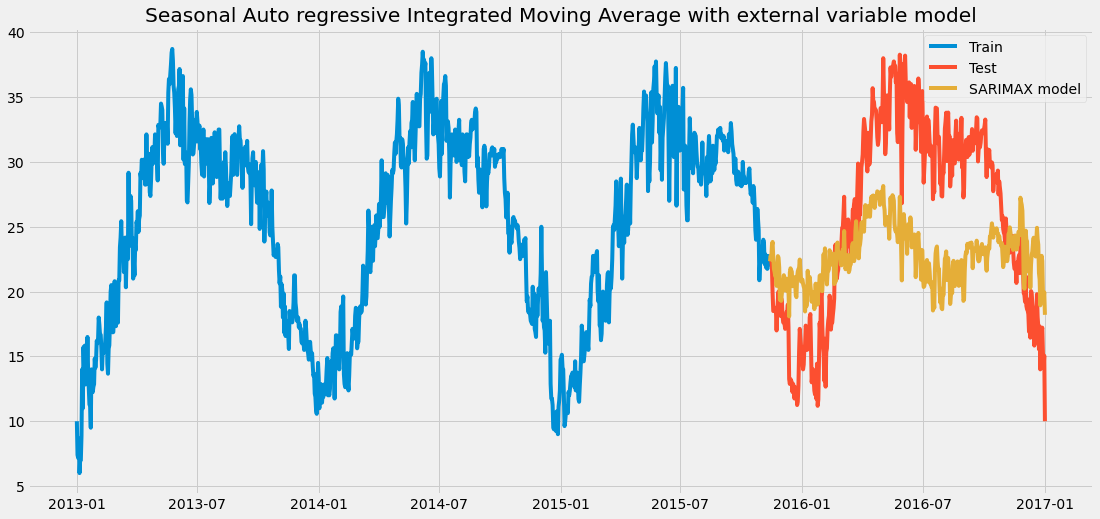

In [14]:
plt.figure(figsize=(17,8))

plt.plot(train['meantemp'], label = 'Train')
plt.plot(test['meantemp'], label = 'Test')
plt.plot(y_sarimax['sarimax_forecast'][test['meantemp'].index.min():], label = 'SARIMAX model')

plt.legend()
plt.title('Seasonal Auto regressive Integrated Moving Average with external variable model')
plt.show()